# Assignment 1-3: Two Layer Neural Network

In [1]:
%load_ext autoreload
%autoreload 2

## Setup codes

In [2]:
import torch
import matplotlib.pyplot as plt
import statistics
import random
import time
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Implementing a Neural Network
본 과제에서는 CIFAR-10 데이터셋에 대해 fully-connected 층으로 구성된 **neural network**를 만들어 classification을 수행해봅니다.

Network는 이전에 구현했던 softmax cross-entropy loss function과 L2 regularization으로 학습합니다.  
그리고 첫 번째 fully-connected layer 뒤에는 **ReLU** activation function으로 사용합니다.

정리하면 모델 구조는 다음과 같습니다<br>
- input → fully connected layer → ReLU → fully connected layer → softmax

두 번째 fully-connected layer의 출력은 각 클래스에 대한 scores입니다. 따라서 ReLU를 사용하지 않습니다.<br>
**Note**: `W`에 대한 regularization을 구현할 때 **regularization term에 1/2를 곱하지 마세요**(계수를 사용하지 말라는 의미입니다).

## Play with a toy data

우리가 구현할 network의 입력은 배치 크기 `N`(`num_inputs`)과 `D`(`input_size`) dimension(차원)을 가진 벡터들입니다.  
hidden layer는 `H`개의 hidden units(`hidden_size`)를 가지며, `C`개의 카테고리(`num_classes`)에 대한 분류 scores를 예측합니다.  
따라서 학습 가능한 **weights**와 **biases**의 shape는 다음과 같습니다:

* W1: 첫 번째 layer의 weights; shape (D, H)
* b1: 첫 번째 layer의 biases; shape (H,)
* W2: 두 번째 layer의 weights; shape (H, C)
* b2: 두 번째 layer의 biases; shape (C,)

### 구현 하기: Forward pass (compute scores)
Linear Classifiers와 마찬가지로, model weights, 이미지와 레이블의 배치를 입력으로 받아 loss와 각 파라미터에 대한 gradient를 반환하는 함수를 작성합니다.<br>
하지만 한 번에 전부 구현하지 않고 여기서는 먼저 **forward pass** 함수만 작성합니다.

먼저 `nn_forward_pass`에서 **weights**와 **biases**를 사용해 모든 입력에 대한 **scores**를 계산하는 **forward pass**를 구현하세요.<br>
scores를 계산한 뒤, 정답과 비교해 보세요. 두 값의 차이는 `1e-10`보다 작아야 합니다.

---

**주의 사항**: 난수 생성기가 CPU와 GPU에서 다르게 작동되기 때문에 아래 score 검증은 GPU에서 실행되는 결과와 호환되지 않습니다.
만약 GPU에서 실행시키는 경우 `correct_scores`를 아래와 같이 변경하고 실행하세요.

```
correct_scores = torch.tensor([
        [ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], dtype=torch.float32, device=scores.device)
```

In [5]:
from utils import get_toy_data, reset_seed
from two_layer_net import nn_forward_pass

reset_seed(0)
toy_X, toy_y, params = get_toy_data(device="cpu")

# TODO: Implement the score computation part of nn_forward_pass
scores, _ = nn_forward_pass(params, toy_X)
print('Your scores:')
print(scores)
print(scores.dtype)
print()
print('correct scores:')
correct_scores = torch.tensor([
        [ 4.5398e-07, -1.9270e-07, -4.8966e-07],
        [ 5.4361e-07,  9.8901e-08,  7.2228e-07],
        [-5.9020e-08,  2.0401e-09,  1.6904e-07],
        [ 2.2207e-07,  5.2379e-08,  2.7437e-07],
        [ 3.0348e-07, -5.1789e-08, -6.1906e-08]], dtype=torch.float32, device=scores.device)
print(correct_scores)
print()

# The difference should be very small. We get < 1e-10
scores_diff = (scores - correct_scores).abs().sum().item()
print('Difference between your scores and correct scores: %.2e' % scores_diff)

Your scores:
tensor([[ 4.5398e-07, -1.9270e-07, -4.8966e-07],
        [ 5.4361e-07,  9.8901e-08,  7.2228e-07],
        [-5.9020e-08,  2.0401e-09,  1.6904e-07],
        [ 2.2207e-07,  5.2379e-08,  2.7437e-07],
        [ 3.0348e-07, -5.1789e-08, -6.1906e-08]])
torch.float32

correct scores:
tensor([[ 4.5398e-07, -1.9270e-07, -4.8966e-07],
        [ 5.4361e-07,  9.8901e-08,  7.2228e-07],
        [-5.9020e-08,  2.0401e-09,  1.6904e-07],
        [ 2.2207e-07,  5.2379e-08,  2.7437e-07],
        [ 3.0348e-07, -5.1789e-08, -6.1906e-08]])

Difference between your scores and correct scores: 2.28e-11


### 구현 하기: Forward pass (compute loss)
이제 `nn_forward_backward`의 첫 번째 부분을 구현합니다.  
여기서는 data loss와 regularization loss를 계산합니다.

- **data loss**는 **softmax cross-entropy loss**를 사용합니다.  
- **regularization loss**는 `W1`, `W2`에 대해 **L2 regularization**을 적용합니다. `b1`, `b2`에는 regularization을 적용하지 않습니다.

아래 코드 셀을 통해 구현된 pass를 확인합니다.
제대로 구현했다면 loss의 차이는 `1e-4` 미만이어야 합니다.

In [7]:
from two_layer_net import nn_forward_backward

reset_seed(0)
toy_X, toy_y, params = get_toy_data(device="cpu")

# TODO: Implement the loss computation part of nn_forward_backward
loss, _ = nn_forward_backward(params, toy_X, toy_y, reg=0.05)
print('Your loss: ', loss.item())
correct_loss = 1.0986121892929077
print('Correct loss: ', correct_loss)
diff = (correct_loss - loss).item()

# should be very small, we get < 1e-4
print('Difference: %.4e' % diff)

Your loss:  1.0986121892929077
Correct loss:  1.0986121892929077
Difference: 0.0000e+00


### 구현하기: Backward pass
이제 `nn_forward_backward` 안에서 전체 네트워크의 backward pass을 구현합니다.<br>`W1`, `b1`, `W2`, `b2`에 대한 loss의 gradient를 계산합니다.  

아래 코드 셀은 numeric gradient checking을 통해 backward pass에서 계산한 analytic gradient가 수치적으로 구한 numeric gradient와 일치하는지 확인합니다.
모든 파라미터에서 relative error가 `1e-4` 이하로 나와야 합니다.

In [8]:
import utils
from two_layer_net import nn_forward_backward

reset_seed(0)

reg = 0.05
toy_X, toy_y, params = get_toy_data(device="cpu", dtype=torch.float64)

# TODO: Implement the gradient computation part of nn_forward_backward
#       When you implement the gradient computation part, you may need to 
#       implement the `hidden` output in nn_forward_pass, as well.
loss, grads = nn_forward_backward(params, toy_X, toy_y, reg=reg)

for param_name, grad in grads.items():
  param = params[param_name]
  f = lambda w: nn_forward_backward(params, toy_X, toy_y, reg=reg)[0]
  grad_numeric = utils.compute_numeric_gradient(f, param)
  error = utils.rel_error(grad, grad_numeric)
  print('%s max relative error: %e' % (param_name, error))

W2 max relative error: 1.143533e-06
b2 max relative error: 5.467207e-10
W1 max relative error: 1.523596e-06
b1 max relative error: 1.572981e-05


### 구현 하기: Train the network
이 network는 Softmax 분류기 때와 마찬가지로 SGD로 학습합니다.

`nn_train` 함수를 살펴보고, 비어 있는 부분을 채워 training 파트를 구현하세요.  
또한 학습 도중 주기적으로 prediction을 수행해 accuracy를 추적하므로, `nn_predict`도 함께 구현해야 합니다.

모든 구현을 마친 뒤, 아래 코드를 실행해 toy 데이터에 대해 two-layer network를 학습해 보세요.  
최종 training loss는 1.0 근처여야 합니다.

In [9]:
from two_layer_net import nn_forward_backward, nn_train, nn_predict

reset_seed(0)
toy_X, toy_y, params = get_toy_data(device="cpu")

stats = nn_train(params, nn_forward_backward, nn_predict, toy_X, toy_y, toy_X, toy_y,
                 learning_rate=1e-1, reg=1e-6,
                 num_iters=200, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

Final training loss:  1.0709935426712036


## CIFAR-10 데이터셋에 학습하기
이제 구현한 **two-layer network**가 gradient check를 통과했고 toy 데이터에서도 잘 동작하니 실제 데이터셋에 학습해볼 차례입니다.<br>
아래 코드 셀은 CIFAR-10 데이터를 불러와 classifier를 학습합니다.

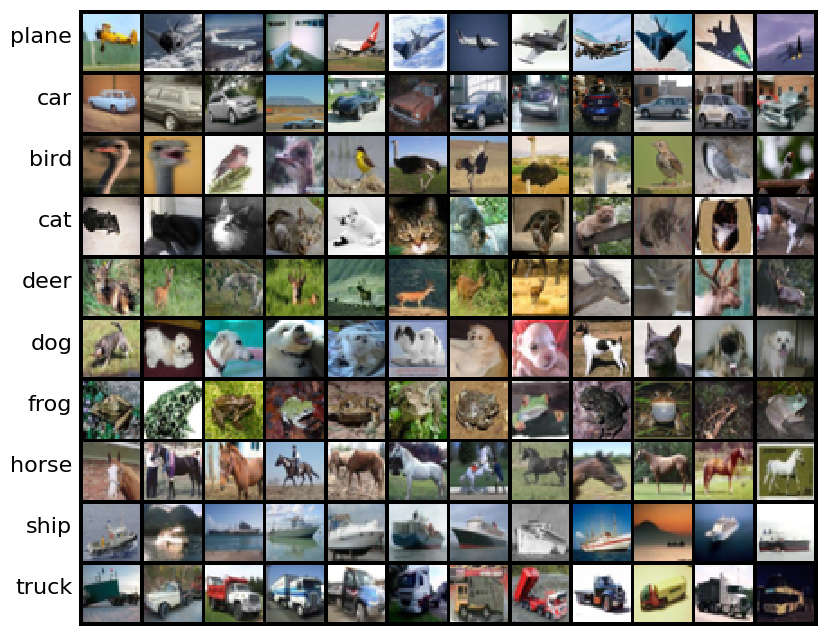

Train data shape:  torch.Size([40000, 3072])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3072])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [10]:
import utils

reset_seed(0)
data_dict = utils.preprocess_cifar10(cuda=False, dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

### Network를 객체 지향적으로 (class) 관리하기
사람마다 구현 스타일이 다르지만 network를 class로 관리하는게 편리합니다.<br>
코드에서는 network를 표현하기 위해 `TwoLayerNet` class로 구현되었습니다.

네트워크의 파라미터들은 인스턴스 변수 `self.params`에 저장됩니다.<br>
여기서 key는 문자열 형태의 파라미터 이름이고, value는 PyTorch `tensor`입니다.

### Network 학습하기

모델을 SGD로 학습합니다. 참고로 여기서는 learning rate를 exponential 형태로 조정하는데 추후 수업 때 배울 내용이니 넘어가도 좋습니다.
<br>
Linear classifier 때와 마찬가지로 아래 코드는 대략 validation accuracy가 10% 내외로 나오게 됩니다.

In [11]:
from two_layer_net import TwoLayerNet

input_size = 3 * 32 * 32
hidden_size = 36
num_classes = 10

# fix random seed before we generate a set of parameters
reset_seed(0)
net = TwoLayerNet(input_size, hidden_size, num_classes, dtype=data_dict['X_train'].dtype, device=data_dict['X_train'].device)

# Train the network
stats = net.train(data_dict['X_train'], data_dict['y_train'],
                  data_dict['X_val'], data_dict['y_val'],
                  num_iters=500, batch_size=1000,
                  learning_rate=1e-2, learning_rate_decay=0.95,
                  reg=0.25, verbose=True)

# Predict on the validation set
y_val_pred = net.predict(data_dict['X_val'])
val_acc = 100.0 * (y_val_pred == data_dict['y_val']).double().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

iteration 0 / 500: loss 2.302864
iteration 100 / 500: loss 2.302711
iteration 200 / 500: loss 2.302587
iteration 300 / 500: loss 2.302557
iteration 400 / 500: loss 2.302490
Validation accuracy: 9.52%


아래 코드는 loss와 classification accuracy를 시각화합니다.<br>
그리고 network의 weight가 어떻게 학습되었는지 vision 관점에서도 보여줍니다.

학습이 잘 되지 않았으니 모두 엉망으로 결과가 나오는 것을 확인할 수 있습니다.

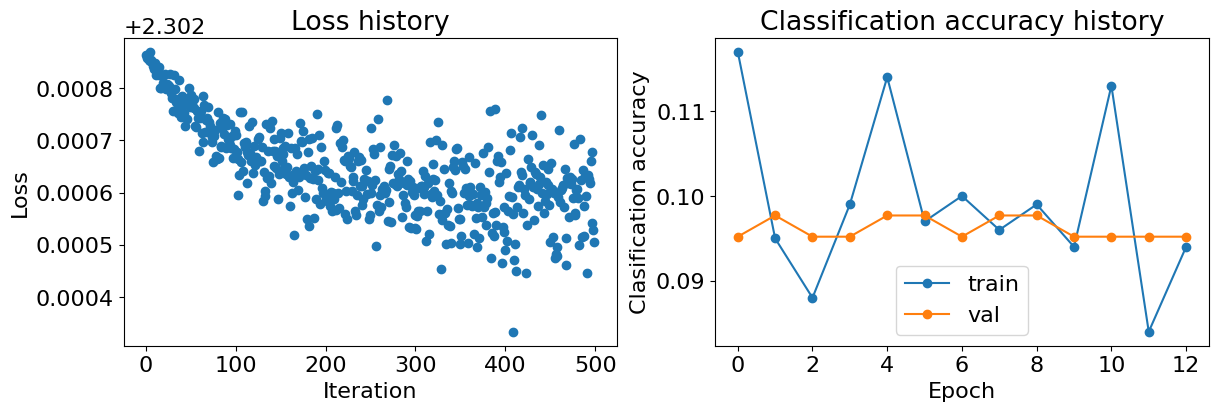

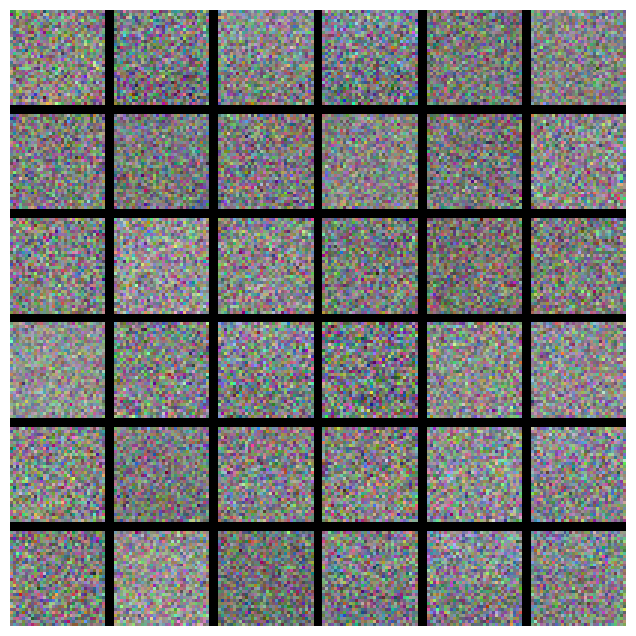

In [12]:
from utils import plot_stats, show_net_weights

plot_stats(stats)
show_net_weights(net)

## 모델 개선하기

위 loss history 시각화를 보면 loss가 거의 선형적으로 (너무 천천히) 감소하는 걸 볼 수 있습니다. 이는 learning rate가 너무 낮을 수 있기 때문에 그럴 수 있습니다.  
또한 training accuracy와 validation accuracy 사이에 간극이 거의 없는데 이는 모델의 capacity (능력 or 용량)가 낮아서 모델 크기를 키울 필요가 있음을 의미합니다.  

반대로 모델을 지나치게 크게 만들면 overfitting이 발생하기 쉽고, 그 결과 training accuracy와 validation accuracy 사이의 간극이 크게 벌어지는 현상을 보게됩니다.

### Capacity?
초기 모델은 training set과 validation set에서 매우 비슷한 성능을 보입니다.  
이는 모델이 underfitting 상태임을 의미하며, capacity를 늘리면 성능이 향상될 수 있다는 뜻입니다.  

Neural network의 capacity를 키우는 한 가지 방법은 hidden layer의 크기를 늘리는 것입니다.  
여기서는 hidden layer 크기를 키웠을 때 성능이 어떻게 달라지는지 확인합니다.  
일반적으로 hidden layer의 크기가 커질수록 validation accuracy가 높아지지만, 너무 커지면 성능 향상이 점차 줄어드는 diminishing returns 현상이 나타날 수 있습니다.

참고로 아래 실험부터는 다양한 하이퍼파라미터 (hidden layer 등등)에 대해 실험을 하기 때문에 CPU에서 실행하는 본 과제에서는 시간이 오래 소요될 수 있습니다.

train with hidden size: 2
train with hidden size: 8
train with hidden size: 32
train with hidden size: 128


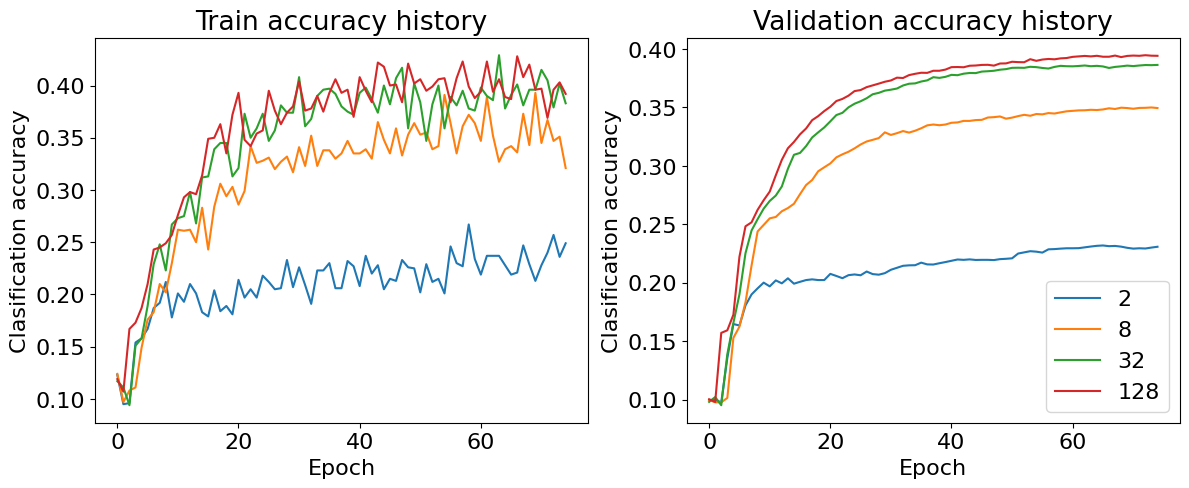

In [13]:
from utils import plot_acc_curves
from two_layer_net import TwoLayerNet

hidden_sizes = [2, 8, 32, 128] 
lr = 0.1
reg = 0.001

stat_dict = {}
for hs in hidden_sizes:
  print('train with hidden size: {}'.format(hs))
  # fix random seed before we generate a set of parameters
  reset_seed(0)
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[hs] = stats

plot_acc_curves(stat_dict)

### Regularization?
Train accuracy와 validation accuracy의 차이가 작았던 또 다른 이유는 regularization일 수 있습니다.  
특히 regularization coefficient가 너무 크면 모델이 training data를 제대로 학습하지 못할 수 있습니다.  

이 현상을 확인하기 위해 다른 hyperparameter는 고정하고 regularization strength를 바꿔가며 여러 모델을 학습시켜 볼 수 있습니다.  

regularization strength가 지나치게 크면 validation set에서의 모델 성능이 오히려 떨어지는 것을 확인할 수 있습니다.

train with regularization: 0
train with regularization: 1e-05
train with regularization: 0.001
train with regularization: 0.1


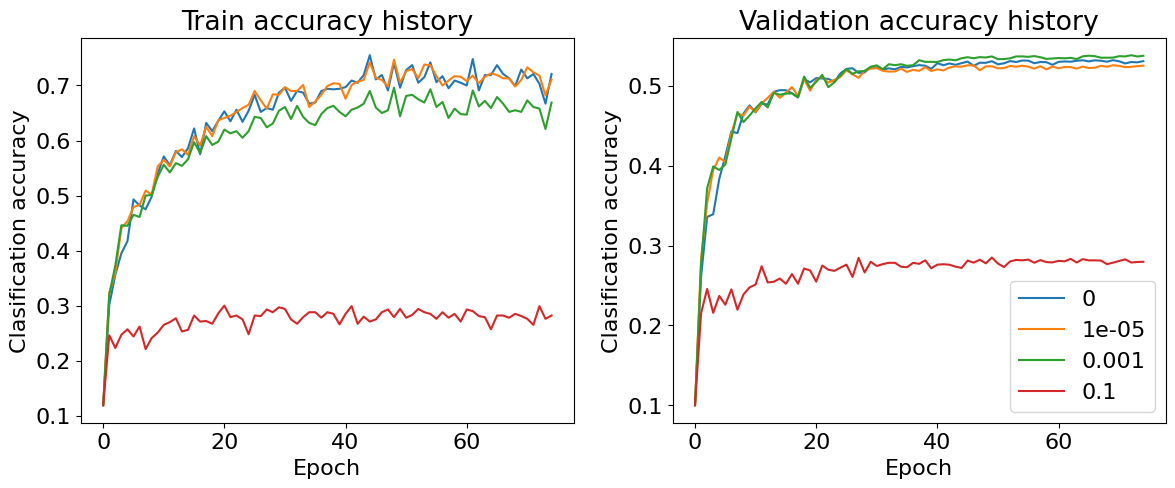

In [14]:
from utils import plot_acc_curves
from two_layer_net import TwoLayerNet

hs = 128
lr = 1.0
regs = [0, 1e-5, 1e-3, 1e-1]

stat_dict = {}
for reg in regs:
  print('train with regularization: {}'.format(reg))
  # fix random seed before we generate a set of parameters
  reset_seed(0)
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[reg] = stats

plot_acc_curves(stat_dict)

### Learning Rate?
물론 learning rate도 매우 중요한 하이퍼파라미터 입니다.

train with learning rate: 0.0001
train with learning rate: 0.01
train with learning rate: 1.0
train with learning rate: 100.0


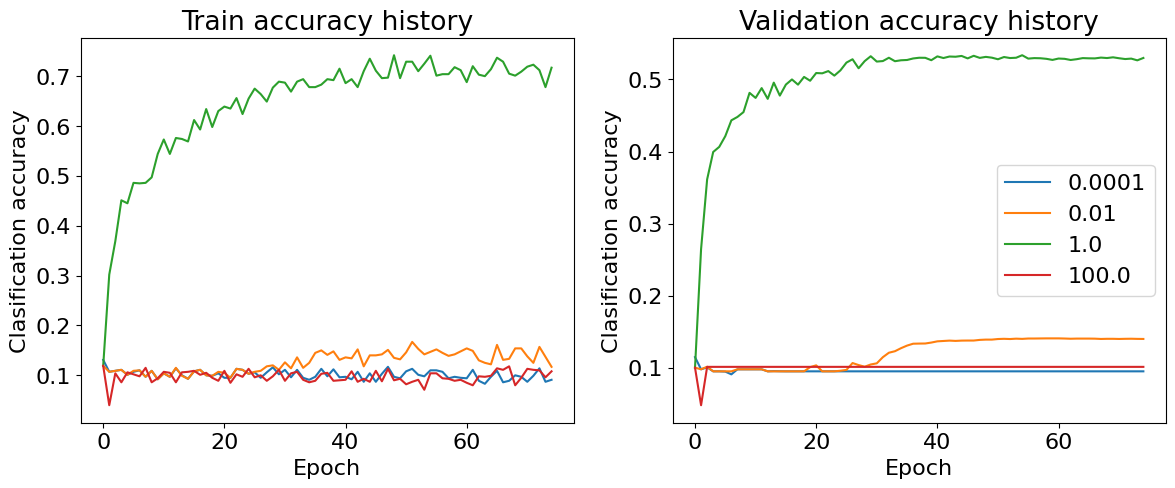

In [15]:
from utils import plot_acc_curves
from two_layer_net import TwoLayerNet

hs = 128
lrs = [1e-4, 1e-2, 1e0, 1e2]
reg = 1e-4

stat_dict = {}
for lr in lrs:
  print('train with learning rate: {}'.format(lr))
  # fix random seed before we generate a set of parameters
  reset_seed(0)
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[lr] = stats

plot_acc_curves(stat_dict)